In [45]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
import csv
import random
import numpy as np
import cv2
import mimetypes
import fnmatch
import seaborn as sns
from collections import Counter, defaultdict
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time
from progress.bar import IncrementalBar
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import io
from pytorch_lightning.callbacks import Callback
from datetime import datetime, date, time
from PIL import Image
import itertools 

## Dataset

In [14]:
labels_map = {
    "Benign": 0,
    "InSitu": 1,
    "Invasive": 2,
}

In [15]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, paths_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        f = open(paths_file, 'r')
        self.img_paths = f.read().split('\n')
        f.close()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = read_image(img_path)
        img_folder = int(img_path.split("/")[1])
        label_name = self.img_labels.iloc[img_folder - 1][4]
        label = torch.tensor(labels_map[label_name])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        image = image.float()
        return image, label

Feature batch shape: torch.Size([120, 3, 256, 256])
Labels batch shape: 120
torch.Size([256, 256, 3])


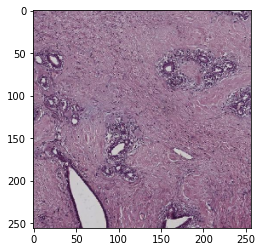

Label: 0


In [16]:
transform = transforms.Resize([256, 256])
dataset = ImageDataset('burnasyan_Br.csv', 'little_train_paths.txt', transform = transform)
dataloader = DataLoader(dataset, batch_size=120, shuffle=True)
features, labels = next(iter(dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {len(labels)}")
img = features[0].squeeze().permute(1, 2, 0).int()
print(img.shape)
label = labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [17]:
print('Size of dataset: ', len(dataset))

Size of dataset:  30000


### Device

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
features = features.to(device)
labels = labels.to(device)

Using cuda device


## CNN

In [19]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc3 = nn.Linear(21600, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc3(x)
        return x


my_cnn = MyCNN().to(device)
print(my_cnn)

MyCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc3): Linear(in_features=21600, out_features=3, bias=True)
)


### Functions for callbacks

In [20]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [21]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    image = Image.open(buf)
    image = image.convert("RGB")
    transform = transforms.ToTensor()
    image = transform(image)
    
    return image

In [38]:
# helper functions

def get_true_classes(input_classes):
    true_classes = []
    for i in range(len(input_classes)):
        input_classes[i] = input_classes[i].to('cpu')
        for item in input_classes[i]:
            true_classes.append(item.item()) 
    out = np.array(true_classes, dtype=np.int64)
    return out

def get_predicted_classes(input_classes):
    pred_classes = []
    for i in range(len(input_classes)):
        input_classes[i] = input_classes[i].to('cpu')
        for item in input_classes[i]:
            pred_classes.append(item.detach().numpy()) 
    pred_classes = np.array(pred_classes, dtype=object).astype(float)
    out = np.argmax(pred_classes, axis = 1)
    return out

def get_classes_probs(input_classes):
    pred_classes = []
    for i in range(len(input_classes)):
        input_classes[i] = input_classes[i].to('cpu')
        for item in input_classes[i]:
            pred_classes.append(item.detach().numpy()) 
    pred_classes = np.array(pred_classes, dtype=object).astype(float)
    return pred_classes

In [39]:
def log_confusion_matrix(epoch, true, pred, class_names):
    
    # Calculate the confusion matrix using sklearn.metrics
    cm = confusion_matrix(true, pred)
    
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    writer.add_image('Confusion matrix', cm_image, epoch)
    
def log_running_loss(running_loss, epoch):
    writer.add_scalar('Training loss', running_loss / 250, epoch)
    
def log_accuracy(true, pred, epoch):
    writer.add_scalar('Accuracy', accuracy_score(true, pred), epoch)
    
def log_rocauc(true, pred, epoch):
    writer.add_scalar('ROC_AUC', roc_auc_score(true, pred,
                      multi_class='ovr', average='weighted'), epoch)
    
def log_precision(true, pred, epoch):
    writer.add_scalar('Precision', precision_score(true, pred, average='weighted'),
                      epoch)
    
def log_recall(true, pred, epoch):
    writer.add_scalar('Recall', recall_score(true, pred, average='weighted'),
                      epoch)


In [40]:
class callback(Callback):
    def __init__(self): pass
    def on_epoch_begin(self, epoch):
        self.epoch = epoch
    def on_epoch_end(self, t, p, class_names, running_loss):
        true = get_true_classes(t)
        pred = get_predicted_classes(p)
        probs = get_classes_probs(p)
        log_confusion_matrix(self.epoch, true, pred, class_names)
        log_running_loss(running_loss, self.epoch)
        log_accuracy(true, pred, self.epoch)
        log_rocauc(true, probs, self.epoch)
        log_precision(true, pred, self.epoch)
        log_recall(true, pred, self.epoch)

In [48]:
logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(logdir + '/cm')
writer.add_graph(my_cnn, features)

In [49]:
my_callback = callback()

In [50]:
summed = 14032 + 1358 + 26649 
weight = torch.tensor([14032, 1358, 26649]) / summed
weight = weight.to(device)
criterion = nn.CrossEntropyLoss(weight=weight)
#criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.SGD(my_cnn.parameters(), lr=1e-5, momentum=0.9)

In [52]:
classes = []
true_classes= []
epochs_num = 100

for epoch in tqdm_notebook(range(epochs_num, epochs_num + 100), desc='epochs'):  # loop over the dataset multiple times
    
    my_callback.on_epoch_begin(epoch) 
    
    running_loss = 0.0
    i = 0
    for data in tqdm_notebook(dataloader, desc='one epoch training'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        true_classes.append(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = my_cnn(inputs)
        classes.append(nn.Softmax(dim=1)(outputs))
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i += 1
    
    my_callback.on_epoch_end(true_classes, classes,
                          ["Benign", "InSitu", "Invasive"],
                          running_loss)
    
    running_loss = 0.0

print('Finished Training')

epochs:   0%|          | 0/100 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [53]:
torch.save(my_cnn.state_dict(), "Saved_my_cnn/" + str(epoch))